In [1]:
import os
import numpy as np
import pandas as pd
import sys
import json
import networkx as nx
import matplotlib.pyplot as plt
from venny4py.venny4py import *
import math

# Add rpy2
%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(ComplexHeatmap)
    library(cowplot)
    library(facefuns)
    library(factoextra)
    library(FactoMineR)
    library(ggh4x)
    library(ggraph)
    library(ggpubr)
    library(ggrain)
    library(ggridges)
    library(ggseg)
    library(ggsegDesterieux)
    library(ggsignif)
    library(glue)
    library(igraph)
    library(LaCroixColoR)
    library(patchwork)
    library(RColorBrewer)
    library(rlist)
    library(scales)
    library(see)
    library(splitstackshape)
    library(tidyverse)
    library(VennDiagram) 
})


# Set cowplot theme
theme_set(theme_cowplot())

In addition: Warning message:
package ‘broom’ was built under R version 4.3.3 


## What is the spatial layout of the three meta-ROIs in the brain?

It is good to first visualize where -- and how much space -- each meta-ROI occupies in the cortex:

In [3]:
# Read in meta-ROI data from .json
with open("hypothesis_driven_ROIs.json") as f:
    meta_ROI_dict = json.load(f)

# Prepare a list of tuples corresponding to each meta-ROI
rows = []
for key, values in meta_ROI_dict.items():
    for value in values:
        rows.append((key, value))

# Convert the list of tuples to a dataframe that maps the meta-ROI to its constituent regions
meta_ROI_df = (pd.DataFrame(rows, columns=['meta_ROI', 'region'])
               .assign(region = lambda x: x.region.str.replace("_", " ")))

pyspi_SPI_info = pd.read_csv("feature_extraction/pyspi_SPI_info.csv")

merging atlas and data by 'region'


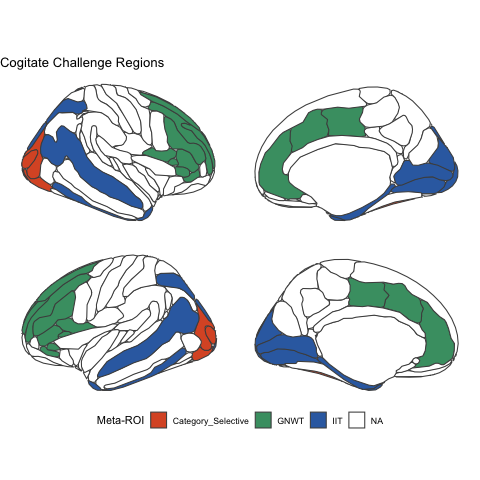

In [4]:
%%R -i meta_ROI_df

# Prepare the meta ROI lookup table dataframe for plotting with ggseg
meta_ROI_df_to_plot <- meta_ROI_df %>% 
  rowwise() %>%
  mutate(meta_ROI = str_split(meta_ROI, "_ROIs")[[1]][1])

# Call ggseg using the desterieux [sic] atlas, mapping the fill color to the meta-ROI
ggseg(atlas = desterieux, 
      mapping = aes(fill = meta_ROI), .data=meta_ROI_df_to_plot,
      color = "gray30", position = "stacked") +
  theme_void() +
  labs(title="Cogitate Challenge Regions", fill="Meta-ROI") +
  scale_fill_manual(values = c("Category_Selective" = "#DB582D",
                               "GNWT" = "#479D72",
                               "IIT" = "#346DB0"),
                    na.value = 'white') +
  theme(legend.position = "bottom")
# ggsave('plots/Cogitate_Meta_ROIs.svg', width=5, height=3, units='in', dpi=300)

## Intra-individual classification performance

In [15]:
intra_individual_classification_path = "/Users/abry4213/data/Cogitate_MEG/derivatives/classification_results/within_participants"
intra_individual_classification_res_list = []

for classification_file in os.listdir(intra_individual_classification_path):
    subject_id = classification_file.split("_")[0]
    classification_df = pd.read_csv(os.path.join(intra_individual_classification_path, classification_file))

    # Drop the 'comparison' column
    if "comparison" in classification_df.columns:
        classification_df = classification_df.drop(columns=["comparison"])

    if "relevance_type" in classification_file:
        classification_df["Classification_Type"] = "Relevance"
    else:
        classification_df["Classification_Type"] = "Stimulus Type"

    # Rename column from subject_id to "subject_id"
    classification_df = classification_df.rename(columns={subject_id: "subject_id"})
    classification_df["subject_id"] = subject_id

    # Append results
    intra_individual_classification_res_list.append(classification_df)

# Concatenate all classification results
intra_individual_classification_res = pd.concat(intra_individual_classification_res_list)

In [53]:
intra_individual_classification_res.head()

,subject_id,SPI,meta_ROI_from,meta_ROI_to,stimulus_presentation,accuracy,Classification_Type,relevance_type,stimulus_combo
0,sub-CB069,cov_EmpiricalCovariance,GNWT,Category_Selective,on,0.503565,Relevance,NaN,NaN
1,sub-CB069,cov_GraphicalLasso,GNWT,Category_Selective,on,0.515459,Relevance,NaN,NaN
2,sub-CB069,cov_GraphicalLassoCV,GNWT,Category_Selective,on,0.501783,Relevance,NaN,NaN
3,sub-CB069,cov_LedoitWolf,GNWT,Category_Selective,on,0.512069,Relevance,NaN,NaN
4,sub-CB069,cov_OAS,GNWT,Category_Selective,on,0.512098,Relevance,NaN,NaN


In [54]:
intra_individual_classification_res_test = intra_individual_classification_res.query("Classification_Type == 'Stimulus Type' & relevance_type == 'Relevant-non-target'").assign(meta_ROI_pair = lambda x: x.meta_ROI_from + "__" + x.meta_ROI_to)

In [56]:
intra_individual_classification_res_test.head()

,subject_id,SPI,meta_ROI_from,meta_ROI_to,stimulus_presentation,accuracy,Classification_Type,relevance_type,stimulus_combo,meta_ROI_pair
0,sub-CA146,cov_EmpiricalCovariance,GNWT,Category_Selective,on,0.472727,Stimulus Type,Relevant-non-target,"('face', 'false')",GNWT__Category_Selective
1,sub-CA146,cov_EmpiricalCovariance,GNWT,Category_Selective,on,0.556410,Stimulus Type,Relevant-non-target,"('face', 'letter')",GNWT__Category_Selective
2,sub-CA146,cov_EmpiricalCovariance,GNWT,Category_Selective,on,0.454545,Stimulus Type,Relevant-non-target,"('face', 'object')",GNWT__Category_Selective
3,sub-CA146,cov_EmpiricalCovariance,GNWT,Category_Selective,on,0.539744,Stimulus Type,Relevant-non-target,"('false', 'letter')",GNWT__Category_Selective
4,sub-CA146,cov_EmpiricalCovariance,GNWT,Category_Selective,on,0.509848,Stimulus Type,Relevant-non-target,"('false', 'object')",GNWT__Category_Selective


/Users/abry4213/anaconda3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Picking joint bandwidth of 0.678
Picking joint bandwidth of 0.717
Picking joint bandwidth of 0.675
Picking joint bandwidth of 0.73


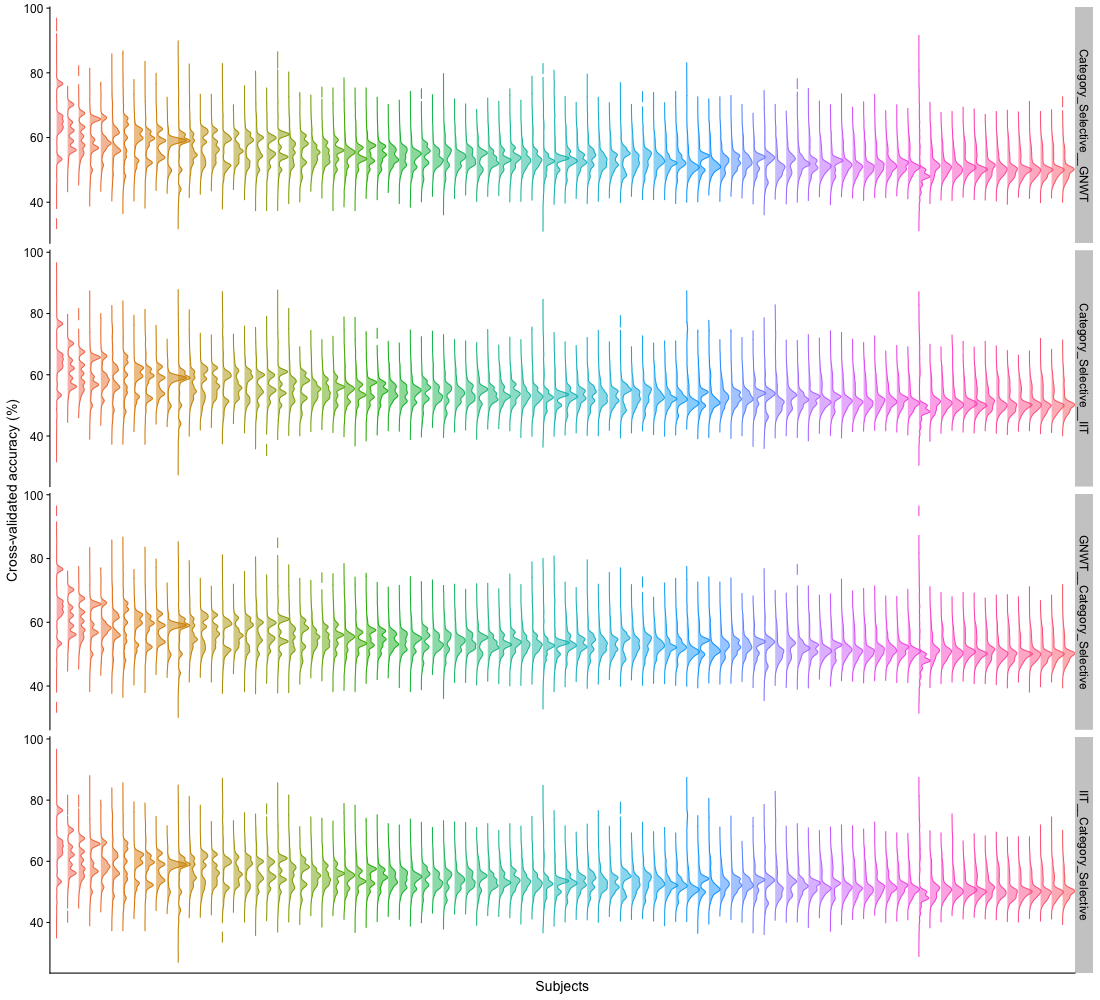

In [57]:
%%R -i intra_individual_classification_res_test -w 1100 -h 1000

intra_individual_classification_res_test %>% 
    mutate(subject_id = fct_reorder(subject_id, accuracy, .fun=mean, .desc=TRUE),
           accuracy = 100*accuracy) %>%
    ggplot(data=., mapping=aes(x=accuracy, y=subject_id, fill=subject_id, color=subject_id)) +
    facet_grid(meta_ROI_pair ~ ., scales="free") +
    geom_density_ridges(scale = 1.75, rel_min_height = 0.00005, alpha=0.5) +
    ylab("Subjects") +
    xlab("Cross-validated accuracy (%)") +
    coord_flip() +
    theme(legend.position="none",
          axis.text.x = element_blank(),
          axis.ticks.x = element_blank()) 